In [35]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [36]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [37]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [38]:
#Setting path to the database file
database_path = "Resources/hawaii.sqlite"


In [39]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

# engine = create_engine("sqlite:///hawaii.sqlite")
# conn = engine.connect()

In [40]:
#This only works with the name of the tables..NOT the file!
hawaii_df = pd.read_sql("SELECT * FROM station", conn)
hawaii_df.head()



,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [41]:
measure_df = pd.read_sql("SELECT * FROM measurement", conn)
measure_df


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [42]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables

Base.prepare(engine, reflect = True)

In [43]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [44]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [45]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [12]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x18e66df49d0>,
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01'}

In [13]:
for row in session.query(Measurement, Measurement.date).limit(5).all():
    print(row)

(<sqlalchemy.ext.automap.measurement object at 0x0000018E66DF4A00>, '2010-01-01')
(<sqlalchemy.ext.automap.measurement object at 0x0000018E66DF4F10>, '2010-01-02')
(<sqlalchemy.ext.automap.measurement object at 0x0000018E66DF4EB0>, '2010-01-03')
(<sqlalchemy.ext.automap.measurement object at 0x0000018E66E060A0>, '2010-01-04')
(<sqlalchemy.ext.automap.measurement object at 0x0000018E66E06100>, '2010-01-06')


In [14]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x18e66e064f0>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0}

In [15]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [16]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [17]:
# Find the most recent date in the data set.

#I can't believe this works, as this is a text column...
engine.execute('SELECT MAX(date) FROM Measurement').fetchall()



[('2017-08-23',)]

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.


# Calculate the date one year from the last date in data set.
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

#Show the calculated year
print("Query Date: ", last_year)

#Run query to gather precip data for one year
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).all()
precip

# Save the query results as a Pandas DataFrame and set the index to the date column. Drop NaN values, as leaving them will alter stats
precip_df = pd.DataFrame(precip)
reset_precip_df = precip_df.set_index('date').dropna()

# Sort the dataframe by date
sorted_precip_df = reset_precip_df.sort_index()

sorted_precip_df.head()



Query Date:  2016-08-23


,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


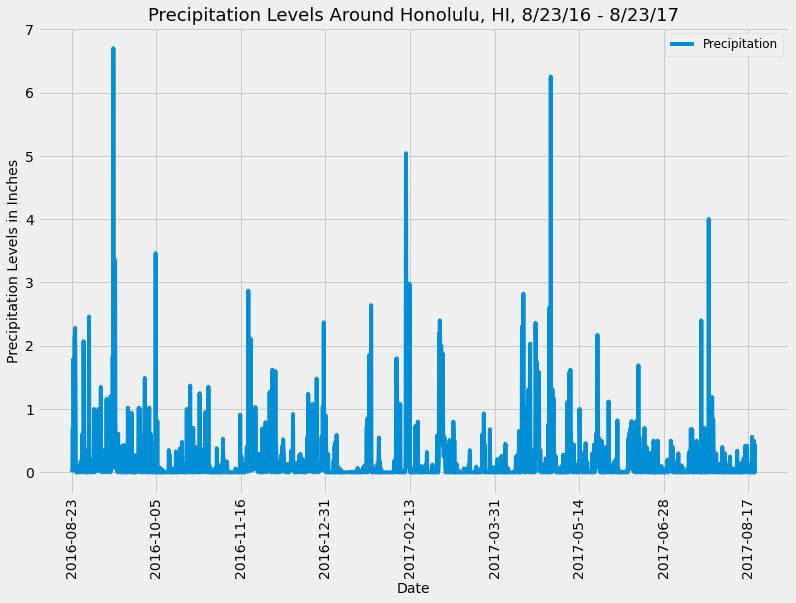

In [30]:
# Use Pandas Plotting with Matplotlib to plot the data

# ax = sorted_precip_df.plot(rot=90, figsize = (12,8))
# ax.set_title("Precipitation Levels Around Honolulu, HI, 8/23/16 - 8/23/17")
# ax.set_ylabel("Precipitation Levels in Inches")
# plt.legend(["Precipitation"], loc = "upper right", prop={"size": 12})
# plt.show()

sorted_precip_df.plot(rot=90, figsize = (12,8))
plt.title("Precipitation Levels Around Honolulu, HI, 8/23/16 - 8/23/17", fontsize = (18))
plt.ylabel("Precipitation Levels in Inches", fontsize = (14))
plt.xlabel("Date", fontsize = (14))
plt.legend(["Precipitation"], loc = "upper right", prop={"size": 12})
plt.show()

#How do i determine what dates are along the x? They don't match....

# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station.station).count()
print(stations)

9


In [32]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
for station, count in active_station:
    print(station, count)


USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()



[(54.0, 85.0, 71.66378066378067)]

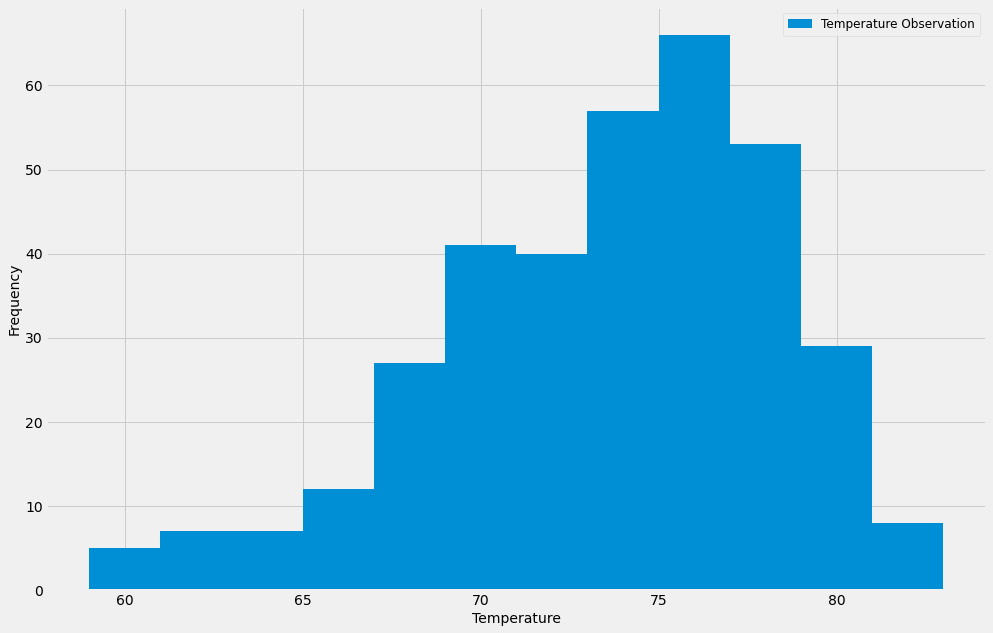

In [166]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Query last 12 months but with temp and filter for most active station
temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= last_year).\
    filter(Measurement.station == "USC00519281").all()
temp

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_df = pd.DataFrame(temp)
reset_temp_df = temp_df.set_index('date')
reset_temp_df

#Create a histogram of temperature observations
reset_temp_df['tobs'].plot.hist(grid=True, figsize=(15, 10), bins = 12)
plt.xlabel("Temperature", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)
plt.legend(["Temperature Observation"], loc = "best", prop={"size": 12})
# plt.title("Temperatures in Hawaii, 8/23/16 - 8/23/17", fontsize = 18)


#Display the plot
plt.show()

# Close session

In [71]:
# Close Session
session.close()